In [101]:
import os
import numpy as np
import cv2
import glob
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from scipy.ndimage.measurements import label

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# from random import shuffle,uniform

from utils import *




Car images
Numbers = 8792
Image size = (64, 64, 3)


Non-Car images
Numbers = 8968
Image size = (64, 64, 3)




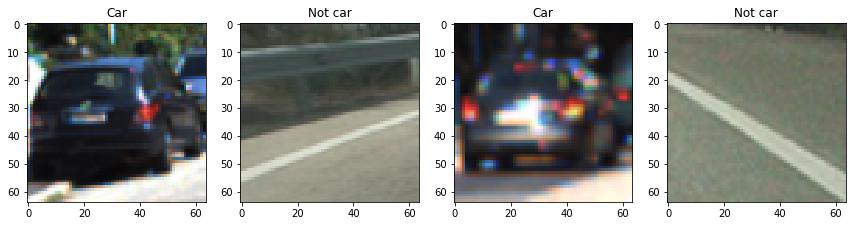

In [124]:
### Load training sample images and create label sets for them
def load_image(folder_name):
    images = []
    for path, subdirs, files in os.walk(folder_name):
       for file in files:
            if file.endswith(".png"):
                image = mpimg.imread(os.path.join(folder_name,path, file))
                images.append(image)
    return images
    
C_images = load_image("/home/nanfly/CarND-Vehicle-Detection/vehicles/vehicles")
C_labels = np.ones(len(C_images))
print('Car images')
print('Numbers =',len(C_images))  
print('Image size =',C_images[0].shape)
print('\n')

NC_images = load_image("/home/nanfly/CarND-Vehicle-Detection/non-vehicles/non-vehicles")
NC_labels = np.zeros(len(NC_images))
print('Non-Car images')
print('Numbers =',len(NC_images))  
print('Image size =',NC_images[0].shape)
print('\n')

### Show car and non-car sample images
fig = plt.figure(figsize=(12,3))
plt.subplot(141)
plt.imshow(C_images[10])
plt.title('Car')
plt.subplot(142)
plt.imshow(NC_images[10])
plt.title('Not car')
plt.subplot(143)
plt.imshow(C_images[20])
plt.title('Car')
plt.subplot(144)
plt.imshow(NC_images[20])
plt.title('Not car')
fig.tight_layout()
plt.show()
fig.savefig('./output_images/car_not_car.png',dpi=fig.dpi)


### Show the number of samples in each class
images = np.append(C_images,NC_images,axis = 0)
labels = np.append(C_labels,NC_labels,axis = 0)


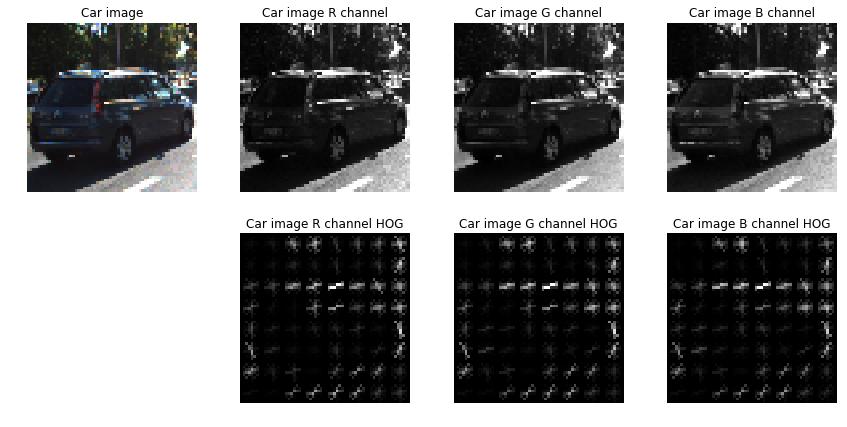

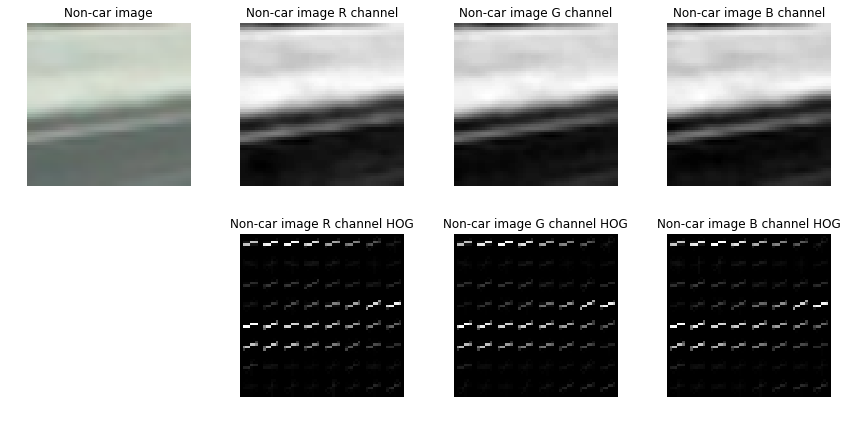

In [142]:
### Define a function to draw HOG features of sample pictures
def sample_hog(car, what = 'Car', cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    fig = plt.figure(figsize=(12,6))
    f00 = fig.add_subplot(2,4,1)
    plt.imshow(car)
    f00.axis('off')
    f00.set_title(what+' image')
    
    
#     car = cv2.cvtColor(car, cv2.COLOR_RGB2YUV)
#     noncar = cv2.cvtColor(noncar, cv2.COLOR_RGB2YUV)
    

    f01 = fig.add_subplot(2,4,2)
    plt.imshow(car[:,:,0],cmap='gray')
    f01.axis('off')
    f01.set_title(what+' image R channel')
    
    f02 = fig.add_subplot(2,4,3)
    plt.imshow(car[:,:,1],cmap='gray')
    f02.axis('off')
    f02.set_title(what+' image G channel')

    f03 = fig.add_subplot(2,4,4)
    plt.imshow(car[:,:,2],cmap='gray')
    f03.axis('off')
    f03.set_title(what+' image B channel')
    
    features, hog_image = hog(car[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
    f04 = fig.add_subplot(2,4,6)
    plt.imshow(hog_image,cmap='gray')
    f04.axis('off')
    f04.set_title(what+' image R channel HOG')
    
    features, hog_image = hog(car[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
    f05 = fig.add_subplot(2,4,7)
    plt.imshow(hog_image,cmap='gray')
    f05.axis('off')
    f05.set_title(what+' image G channel HOG')
    
    features, hog_image = hog(car[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
    f06 = fig.add_subplot(2,4,8)
    plt.imshow(hog_image,cmap='gray')
    f06.axis('off')
    f06.set_title(what+' image B channel HOG')
    
    fig.tight_layout()
    fig.savefig('./output_images/HOG_example_'+what+'.jpg',dpi=fig.dpi)
    plt.show()
    
sample_hog(cars[1],'Car')
sample_hog(notcars[1],'Non-car')

In [71]:
### Training pipeline

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one 
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 5000
cars = C_images[0:sample_size]
notcars = NC_images[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.append(car_features, notcar_features,axis=0).astype(np.float64)   
print('X.shape = ',X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.append(np.ones(len(car_features)), np.zeros(len(notcar_features)),axis=0)


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
# n_predict = 50
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

32.78 Seconds to extract HOG features...
X.shape =  (10000, 5292)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
2.94 Seconds to train SVC...
Test Accuracy of SVC =  0.995


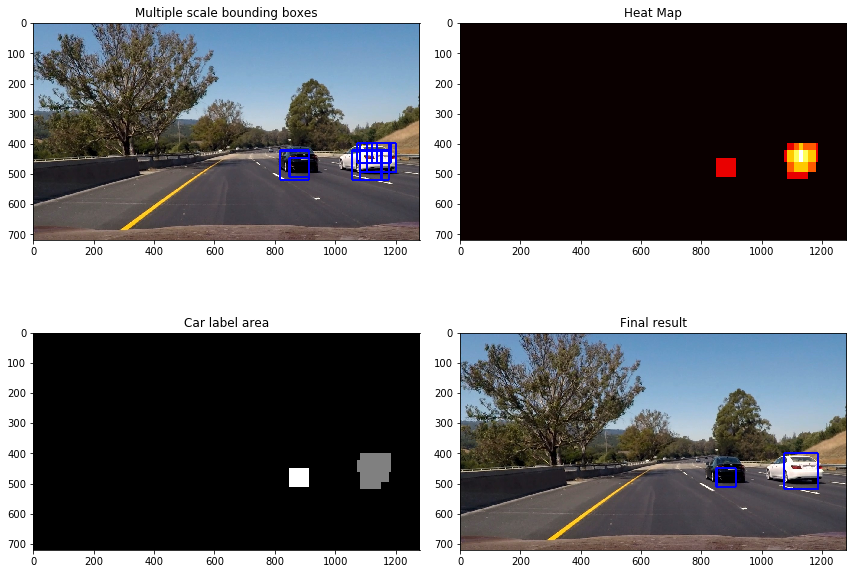

In [200]:
### Car identifying pipeline for a single image


img = mpimg.imread('./test_images/test6.jpg')

# Predict car boxes from a single image
def car_boxes(img, box_list, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
#     draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
    
            test_features = X_scaler.transform((hog_features).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]])
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)     
    
    return box_list

# Extract multi-scale car boxes from a single image    
def car_multi_boxes(img):
    box_list = []
    
    out_img = np.copy(img)
    
    ystart = 400
    ystop = 600
    scale = 1.5
    box_list = car_boxes(img, box_list, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    ystart = 400
    ystop = 600
    scale = 1
    box_list = car_boxes(img, box_list, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    for box in box_list:
        cv2.rectangle(out_img,(box[0][0], box[0][1]),(box[1][0],box[1][1]),(0,0,255),6)   

    return out_img, box_list

# Apply heat map technique and combine car boxes on a single image
def car_single_box(img,box_list,threshold=2):

    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img,heatmap,labels

out_img, box_list = car_multi_boxes(img)
draw_img,heatmap,label_img = car_single_box(img,box_list,1)

fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(out_img)
plt.title('Multiple scale bounding boxes')

plt.subplot(222)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

plt.subplot(223)
plt.imshow(label_img[0],cmap='gray')
plt.title('Car label area')

plt.subplot(224)
plt.imshow(draw_img)
plt.title('Final result')

fig.tight_layout()
fig.savefig('./output_images/image_test.jpg',dpi=fig.dpi)
plt.show()


In [201]:
# Do a simple test on the test video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def cars_invideo(img):
    out_img, box_list = car_multi_boxes(img)
    draw_img,heatmap,_ = car_single_box(img,box_list,1)
    return draw_img
    
video_output = 'test_out.mp4'
clips_in = VideoFileClip("test_video.mp4")
clips_out = clips_in.fl_image(cars_invideo) #NOTE: this function expects color images!!
%time clips_out.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_out.mp4
[MoviePy] Writing video test_out.mp4


 97%|█████████▋| 38/39 [00:22<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_out.mp4 

CPU times: user 2min, sys: 3.35 s, total: 2min 3s
Wall time: 24 s


In [199]:
# Modify the pipeline to allow heat map averaging on several successive frames 
# Apply this new pipeline to the project video

import imageio
import time
from tqdm import *


def boxs_invideo(img):
    box_list = []
    out_img, box_list = car_multi_boxes(img)
    return out_img, box_list


vid = imageio.get_reader('./project_video.mp4',  'ffmpeg')
fps = vid.get_meta_data()['fps']
print(fps)
writer = imageio.get_writer('output_video.mp4', fps=int(fps*4))

box_N = list([])
N = 7
flatten = lambda l: [item for sublist in l for item in sublist]

for im in tqdm(vid):
    image, boxs = boxs_invideo(im)
    box_N.append(boxs)
    if len(box_N) > N:
        del box_N[0]
    tmp = flatten(box_N)
    boxed_image,heat_tmp,_ = car_single_box(im,tmp,3)
    writer.append_data(boxed_image)
writer.close()

  0%|          | 0/1260 [00:00<?, ?it/s]

25.0


100%|██████████| 1260/1260 [13:14<00:00,  1.68it/s]
